In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

In [5]:
df = pd.read_csv("../data/processed/re.csv")
df.head()

,RE,Site,SeqName,CutPos
0,BmtI,GCTAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4588
1,NmeA6CIII,GCCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,5940
2,RceI,CATCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,14830
3,Eco47III,AGCGCT,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4535
4,NgoMIV,GCCGGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,935


In [6]:
df_counts = df.RE.value_counts().reset_index()
df_counts.columns = ["RE", "CuttedSeqs"]
df_counts.head()

,RE,CuttedSeqs
0,BspDI,56384
1,BseCI,56384
2,Bsa29I,56384
3,Bsu15I,56384
4,BshVI,56384


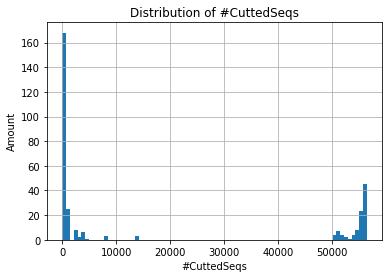

In [7]:
df_counts.hist(bins=80)
plt.title("Distribution of #CuttedSeqs")
plt.xlabel("#CuttedSeqs")
plt.ylabel("Amount")
plt.show()

We can see that many RE cut more than 50000 genomes

In [30]:
# sample best RE
freq_re = df_counts[df_counts.CuttedSeqs > 56100].RE.values
freq_re.shape

(22,)

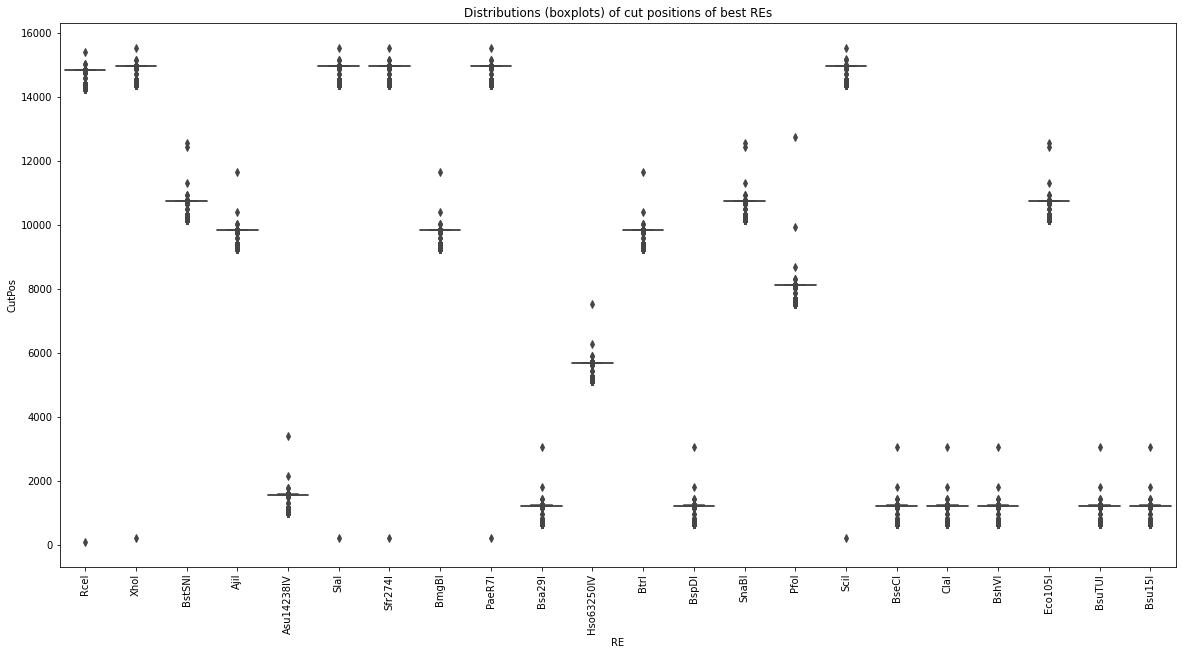

In [9]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="RE", y="CutPos", data=df[df.RE.isin(freq_re)])
plt.xticks(rotation=90)
plt.title("Distributions (boxplots) of cut positions of best REs")
plt.savefig("../figures/cut_position.png", dpi=100)
plt.show()

This distributions are very tight, but there are some outlayers, that could be formed by huge deletions in genomes

## Helix db check

In [11]:
ref = next(SeqIO.parse("../data/external/NC_012920.1.fasta", format="fasta"))

helix = pd.read_csv("../data/external/HelixMTdb_20200327.tsv", sep="\t")
print(helix.shape)
helix.head()

(14324, 12)


,locus,alleles,feature,gene,counts_hom,AF_hom,counts_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants
0,chrM:5,"[""A"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[]
1,chrM:10,"[""T"",""C""]",non_coding,MT-CRb,7,0.000036,1,0.000005,0.91892,0.91892,"[[""H"",7]]","[[""H"",1]]"
2,chrM:11,"[""C"",""T""]",non_coding,MT-CRb,0,0.000000,1,0.000005,0.60714,0.60714,[],"[[""H"",1]]"
3,chrM:12,"[""T"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""D"",1]]",[]
4,chrM:16,"[""A"",""T""]",non_coding,MT-CRb,273,0.001393,4,0.000020,0.68971,0.92188,"[[""K"",246],[""U"",12],[""H"",7],[""V"",2],[""B"",1],[""...","[[""K"",2],[""L3"",1],[""U"",1]]"


In [12]:
assert helix.shape[0] == helix.locus.str.startswith("chrM:").sum()

In [13]:
helix["Pos"] = helix.locus.str.replace("chrM:", "").astype(int)

In [14]:
len(ref)

16569

### Get almost constant positions
```
maximal_AF = .00002 (1 / 50_000)
```

In [68]:
maximal_AF = .00002
genome_len = len(ref)

constant_pos = sorted(set(range(genome_len)).difference(
    helix[(helix.AF_hom > maximal_AF) | (helix.AF_het > maximal_AF)].Pos.values)
)
constant_pos[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### Get almost constant sequencies

In [69]:
sequentials = []
cur_seq = [constant_pos[0]]
for pos in constant_pos[1:]:
    if pos == cur_seq[-1] + 1:
        cur_seq.append(pos)
    else:
        if len(cur_seq) > 5:
            sequentials.append(cur_seq)
        cur_seq = [pos]

print(len(sequentials), "constant sequences in mt-genome > 5nt")
print("Sizes:", list(map(len, sequentials)))

226 constant sequences in mt-genome > 5nt
Sizes: [10, 6, 7, 7, 17, 7, 9, 13, 15, 7, 7, 7, 12, 6, 9, 9, 9, 13, 10, 17, 6, 6, 10, 8, 13, 6, 8, 9, 30, 8, 8, 26, 18, 9, 12, 10, 13, 6, 6, 24, 6, 20, 15, 11, 12, 9, 8, 9, 19, 6, 9, 8, 8, 29, 11, 8, 7, 7, 13, 7, 10, 7, 6, 9, 9, 7, 11, 6, 15, 13, 17, 15, 10, 16, 10, 13, 7, 10, 10, 6, 7, 8, 9, 6, 6, 6, 14, 7, 8, 37, 35, 13, 8, 6, 17, 7, 24, 6, 9, 14, 13, 8, 16, 10, 9, 12, 11, 8, 12, 26, 6, 10, 13, 8, 7, 21, 30, 11, 8, 23, 6, 10, 6, 6, 6, 6, 6, 11, 11, 13, 8, 6, 6, 7, 13, 12, 13, 9, 15, 16, 12, 7, 14, 12, 11, 7, 8, 7, 11, 10, 11, 6, 7, 6, 7, 8, 7, 12, 16, 9, 13, 20, 9, 8, 7, 8, 6, 7, 7, 8, 8, 8, 8, 8, 14, 13, 8, 11, 7, 7, 6, 6, 8, 6, 8, 8, 6, 7, 7, 8, 8, 7, 8, 11, 8, 8, 8, 8, 14, 9, 6, 6, 14, 7, 14, 12, 11, 6, 7, 8, 8, 9, 6, 8, 20, 15, 6, 16, 18, 6, 13, 8, 12, 6, 8, 6]


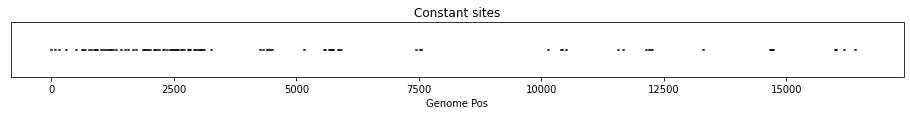

In [70]:
plt.figure(figsize=(16, 1))
for seq in sequentials:
    x = [seq[0], seq[-1]]
    y = [2, 2]
    plt.plot(x, y, 'k')
plt.yticks([])
plt.xlabel("Genome Pos")
plt.title("Constant sites")
plt.show()

There are a lot of nearly constant subsequences in human mtDNA according to Helix DB

### Look at distinct restrictase site positions annotation in Helix

In [101]:
# most efficient REs
freq_re

array(['BspDI', 'BseCI', 'Bsa29I', 'Bsu15I', 'BshVI', 'BsuTUI', 'ClaI',
       'Hso63250IV', 'SnaBI', 'Eco105I', 'BstSNI', 'RceI', 'SciI', 'XhoI',
       'SlaI', 'PaeR7I', 'Sfr274I', 'PfoI', 'AjiI', 'BtrI', 'BmgBI',
       'Asu14238IV'], dtype=object)

### CutPos distributions (in quantile view) for most efficient RE

In [94]:
bgr = df[df.RE.isin(freq_re)].groupby("RE")

bgr.apply(lambda x: pd.Series({
    "Site": x.Site.sample().values[0],
    "CutPos_Q2": x.CutPos.quantile(.02),
    "CutPos_Q50": x.CutPos.quantile(.5),
    "CutPos_Q99": x.CutPos.quantile(.99),
}))

,Site,CutPos_Q2,CutPos_Q50,CutPos_Q99
RE,,,,
AjiI,CACGTC,9816.0,9828.0,9833.0
Asu14238IV,CGTRAC,1556.0,1562.0,1566.0
BmgBI,CACGTC,9816.0,9828.0,9833.0
Bsa29I,ATCGAT,1211.0,1217.0,1221.0
BseCI,ATCGAT,1211.0,1217.0,1221.0
BshVI,ATCGAT,1211.0,1217.0,1221.0
BspDI,ATCGAT,1211.0,1217.0,1221.0
BstSNI,TACGTA,10725.0,10737.0,10742.0
Bsu15I,ATCGAT,1211.0,1217.0,1221.0


### Positions of **ClaI**
[1214, 1219]

In [109]:
clai_pos = list(range(1214-1, 1220+1))

### Our variations for positions of **ClaI**

In [110]:
gs  = pd.read_csv("../data/processed/genomes_summary.tsv", sep="\t")
gs[gs.Pos.isin(clai_pos)]

,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-
1212,1213,0,56439,0,0,0,0,0,0,0,0,0,0,0,0,4,2
1213,1214,0,56439,0,0,0,0,0,0,0,0,0,0,0,0,5,1
1214,1215,0,0,56439,1,0,0,0,0,0,0,0,0,0,0,5,0
1215,1216,0,0,0,56440,0,0,0,0,0,0,0,0,0,0,5,0
1216,1217,56440,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
1217,1218,0,56440,0,0,0,0,0,0,0,0,0,0,0,0,5,0
1218,1219,0,0,56439,0,0,0,0,0,0,0,0,0,0,0,6,0
1219,1220,0,56439,0,0,0,0,0,0,0,0,0,0,0,0,6,0


### Helix-db varitations for positions of **ClaI**

In [111]:
_cols = ["locus", "alleles", "AF_hom", "AF_het"]
helix[helix.Pos.isin(clai_pos)][_cols]

,locus,alleles,AF_hom,AF_het
1435,chrM:1214,"[""A"",""G""]",0.000000,0.000005
1436,chrM:1215,"[""T"",""C""]",0.000000,0.000010
1437,chrM:1219,"[""T"",""C""]",0.000005,0.000010
1438,chrM:1220,"[""A"",""ACTACCTGACCGGCGAGACATTCCAGCTCCCCGCCGTCAC...",0.000000,0.000005


### Result description
ClaI (best candidate) site for reference genome is in [1214, 1219]. 
- [Our analysis](../data/processed/genomes_summary.tsv) shows that this positions are almost fully constant except one gap in 1214 pos one C in 1215 pos;
- Helix database show that there are 3 variations (table above), and allele frequency (AF) for them are extremely low even for heteroplasmic calls. Full helix description of these variations are below


In [112]:
helix[helix.Pos.isin(clai_pos)]

,locus,alleles,feature,gene,counts_hom,AF_hom,counts_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants,Pos
1435,chrM:1214,"[""A"",""G""]",rRNA_gene,MT-RNR1,0,0.000000,1,0.000005,0.096591,0.096591,[],"[[""H"",1]]",1214
1436,chrM:1215,"[""T"",""C""]",rRNA_gene,MT-RNR1,0,0.000000,2,0.000010,0.178110,0.272730,[],"[[""L1"",1],[""L2"",1]]",1215
1437,chrM:1219,"[""T"",""C""]",rRNA_gene,MT-RNR1,1,0.000005,2,0.000010,0.096162,0.102890,"[[""J"",1]]","[[""I"",1],[""J"",1]]",1219
1438,chrM:1220,"[""A"",""ACTACCTGACCGGCGAGACATTCCAGCTCCCCGCCGTCAC...",rRNA_gene,MT-RNR1,0,0.000000,1,0.000005,0.037037,0.037037,[],"[[""H"",1]]",1220


ARF - Alternate Read Fraction = (counts of reads supporting the alternate allele) / (count of all reads at this position)

AF_(hom/het) - allele frequency for homoplasmic or heteroplasmic variants